<a href="https://colab.research.google.com/github/sclaudiobr/algoritmos-py/blob/master/GeoCloud01_Altimetria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoCloud 01 - Modelagem Digital de Elevação
<p> Neste algoritmo vamos aplicar uma ferramenta para selecionar uma área correspondente a abrangência dos limites de um município da base de dados do <i>IBGE</i>, através das biblioteca [geoBR](https://pypi.org/project/geobr/), recortar o quadrante sobre os dados do modelo de digital de elevação (MDE 30 metros) disponível na base de dados da USGS, através da biblioteca [elevation](https://pypi.org/project/elevation/), realizar o tratamento para correção de fluxos e sumidouros sobre os dados de elevação, e a extração dos valores de declividade através da biblioteca [richdem](https://pypi.org/project/richdem/), operacionalizar a conversão coma as bibliotecas [shapely, geopandas e rasterio], e apresentação através das bibliotecas [contextily e mathplotlib.pyplot]. O processo se incia com a configuração do ambiente e importação dos dados, seguidos do recorte da área de interesse e conversão para UTM, finalizando com reclassificação do mapa de declividade e exportação do projeto em uma pasta zipada.
<p>

@autor Claudio Roberto Oliveira da Silva 
<p>MSc. Modelagem Computacional, Eng. Civil - COPPE/UFRJ<p>
<p>Tecnólogo de Geoprocessamento, Cursando - UFSM<p>
<p>email: <a href= "mailto:claumao@gmail.com"> claumao@gmail.com</a>
<p> Repositório: <a href="https://github.com/sclaudiobr/"> GitHub</a>

In [ ]:
# INSTALAR BIBLIOTECAS EXTERNAS
!pip install geobr # Base de dados do IBGE, Malhas municipais, biomas, microrregiões, sedes
!pip install elevation # Base de dados de elevação
!pip install richdem # Ferramenta de processamento de dados de elevação
!pip install rasterio # manipulação de arquivos raster/GDAL
!pip install contextily # basemap
#!pip install ipywidgets # uso posterior
#!pip install ipyleaflet # uso posterior

In [ ]:
# IMPORTANDO AS BIBLIOTECAS
import geobr as br
import geopandas as gpd
import os
import numpy as np
from osgeo import gdal
import elevation as mde
import richdem as rd
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
import contextily as ctx

%matplotlib inline
!eio selfcheck
# cria os diretórios
!mkdir proj
!mkdir proj/shp
!mkdir proj/raster
!mkdir proj/raster/utm
# apaga os diretório
#!rm -r proj

Your system is ready.


In [ ]:
# ACESSANDO OS DADOS DENTRO DO REPOSITÓRIO GEOBR
## salva a filtragem na base do IBGE na variável df
df = br.read_municipality(code_muni='RS')
rs = df
### Refina a busca por municípios
df = df[df.name_muni=='Silveira Martins']
df = gpd.GeoDataFrame(df)
print("Sistemas Geodésico:",df.crs.geodetic_crs)
print('----------------------')
print('')
# Converte para o datum WGS84
df = df.to_crs(crs='EPSG:4326')
print("Novo Sistema Geodésico:",df.crs.geodetic_crs)
print('-------------------------------')
print('')
dfbox = box(*df.total_bounds).bounds
latitude,longitude = np.array(dfbox)[1],np.array(dfbox)[2]
# salva os arquivos no formato shapefile
df.to_file('./proj/shp/df.shp', driver='ESRI Shapefile')

Sistemas Geodésico: GEOGCRS["SIRGAS 2000",DATUM["Sistema de Referencia Geocentrico para las AmericaS 2000",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore."],BBOX[-59.87,-122.19,32.72,-25.28]],ID["EPSG",4674]]
----------------------

Novo Sistema Geodésico: GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)

434    118.638828
dtype: float64 km2


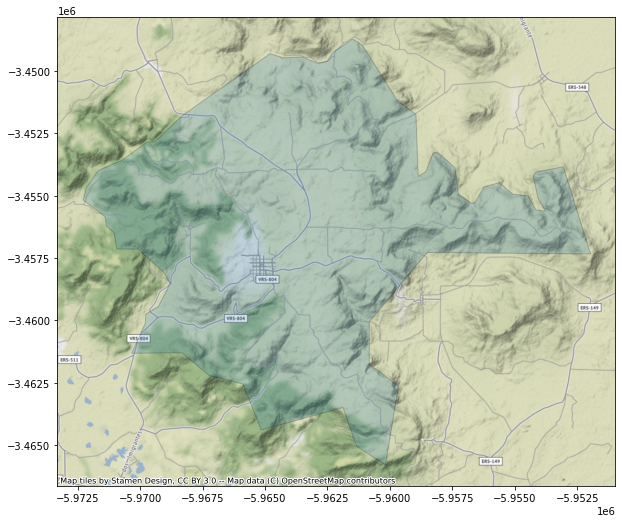

In [ ]:
df = df.to_crs('EPSG:3857') # converte para Cartesiano (Transverso Mercator)
                            # este basemap  só aceita cartesiano
ax = df.plot(figsize=(10, 10), alpha=0.2, edgecolor='k')
ctx.add_basemap(ax)
# converte de volta para SIRGAS 2000UTM 22S para calcular a área
print('Área do Município:',df.to_crs('EPSG:31982').area/1000000,'km2') 

# ALTIMETRIA

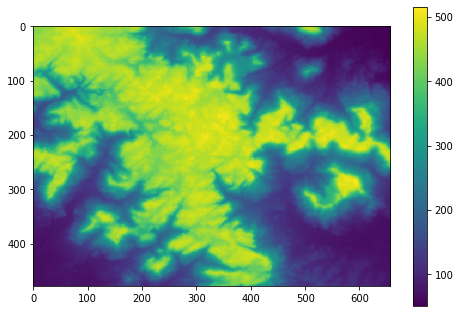

In [ ]:
# Recorte da área de estudo e salva no arquivo tif
mde.clip(bounds= dfbox, output='/content/proj/raster/sm.tif')
# gera a figura de plotagem
matplotlib.rcParams['figure.figsize'] = (8, 5.5)
# Define a pasta de trabalho
dem_path = os.path.join(os.getcwd(), 'proj/raster/sm.tif')
dem = rd.LoadGDAL(dem_path)
# preenche os espaços (buracos na imagem)
fill = rd.FillDepressions(dem, epsilon=False, in_place=False, topology='D8')
beau_breached = rd.BreachDepressions(fill, in_place=False)
rd.SaveGDAL('proj/raster/fill_dem.tif',beau_breached)
plt.imshow(beau_breached, interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
import fiona
import rasterio
import rasterio.mask
with fiona.open("proj/shp/df.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rasterio.open("proj/raster/fill_dem.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("proj/raster/masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
# converter o sistema de coordenadas CGS-WGS 84 para UTM-SIRGAS 2000 zona 22S
!gdalwarp -s_srs epsg:4326 -t_srs epsg:31982 /content/proj/raster/masked.tif /content/proj/raster/utm/masked_utm.tif

Creating output file that is 636P x 535L.
Processing input file /content/proj/raster/masked.tif.
Using internal nodata values (e.g. -32768) for image /content/proj/raster/masked.tif.
Copying nodata values from source /content/proj/raster/masked.tif to destination /content/proj/raster/utm/masked_utm.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


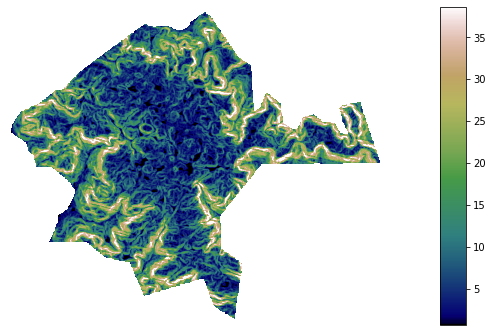

In [ ]:
fdem = rd.LoadGDAL('proj/raster/utm/masked_utm.tif')
slope = rd.TerrainAttribute(fdem, attrib='slope_degrees')
rd.rdShow(slope, axes=False, cmap='gist_earth', figsize=(8, 5),)
plt.show()
rd.SaveGDAL('proj/raster/utm/slope.tif' , slope)

In [ ]:
# RECLASSIFICAÇÂO do MAPA DE DECLIVIDADE
import copy
#Realiza uma cópia da matriz
new_matrix = copy.copy(slope)
# reclassificação =  converte os intervalos de declividade para classes de valores inteiros
new_matrix[np.where(slope < 15)] = 0
new_matrix[np.where((15 <= slope) & (slope < 20)) ] = 1
new_matrix[np.where((20 <= slope) & (slope < 30)) ] = 2
new_matrix[np.where((30 <= slope) & (slope < 40  )) ] = 3
new_matrix[np.where((40 <= slope) & (slope < 50)) ] = 4
new_matrix[np.where((slope > 50)) ] = 5
# salva amatriz de dados
rd.SaveGDAL('proj/raster/utm/slope_reclas.tif' , new_matrix)

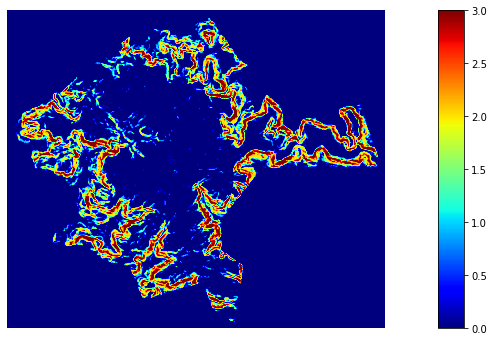

In [ ]:
reclass = rd.LoadGDAL('proj/raster/utm/slope_reclas.tif',no_data=None)
rd.rdShow(reclass, axes=False, cmap='jet', figsize=(8, 5),)
plt.show()


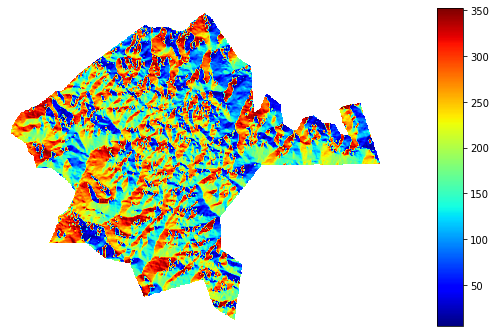

In [ ]:
aspect = rd.TerrainAttribute(fdem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8,5))
plt.show()
rd.SaveGDAL('proj/raster/utm/aspect.tif' , aspect)

In [ ]:
# Comprimindo a pasta do projeto
import zipfile
import os
fantasy_zip = zipfile.ZipFile('projeto.zip', 'w')
for folder, subfolders, files in os.walk('./proj/'):
    for file in files:
        fantasy_zip.write(os.path.join(folder, file), file, compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.close()